# Compute Received Powers from Shout CW Experiment

This Python notebook goes through steps to view received sampled data and compute the power of those signals.
The steps involved are:
(0. If this is running in a Google Colab jupyter notebook, some instructions on uploading files.)
1. Load the data and metadata from the JSON experimental parameters file and HDF5 data file.
2. Plot the received signals in the time domain and the frequency domain
3. Compute the received power in the narrowband received signal
4. Compare path lengths to the measured received powers

Look for questions below, marked with the whale emoji: 🐋

**Save your work as you go. Turn in your completed .ipynb or a pdf of it to the Canvas assignment.**

**Type your name here**

## 0. Instructions when Running this Notebook in Google Colab

✋ First, go to the file menu on the colab File menu and `Save a Copy in Drive`.  This is because the original shared doc is a read only copy.

This python notebook came from [our page](https://github.com/npatwari/).  

The following instructions assume you have the measurement zip file(s) from a run of Shout. 

In colab, we have to upload any file that colab needs besides this .ipynb file.  In particular we need to load the data files.  Currently colab requires us to upload one file at a time.  Because we're impatient, we zipped all of the data folder and its included files together, and we'll upload that one zip file, and then unzip it.

To upload the file:
 - **Click on the folder icon** at the leftmost column of this page.  Then, you should see a `..` folder and a `sample_data` folder, and four icons above that directory listing.
 - **Click on the Upload icon**, which looks like a piece of paper with an up arrow on it.  
 - **Select and upload** the `<your-file-name>.zip` file (or whatever your measurement zip file is called). It asks you to confirm that it will delete them when your session expires (which means you need to do it again if the session expires).  Click OK.
 - **Run the exec command below** Uncomment the command so that it starts with the exclamation point (`!unzip <your-file-name>.zip`, where you type in your file's name); run it; and then wait for it to unzip, which may take a few seconds. 

In [1]:
# !unzip data.zip

## 1. Load the data and metadata from the JSON experimental parameters file and HDF5 data file

This section first loads the packages we'll need across this notebook. Then, it defines functions to load the JSON and the HDF5 data file. Finally, the user changes the variables that describe the folder containing the JSON and HDF5 files:

`folder = "./data/Shout_meas_08-26-2025_13-23-48"`
`jsonfile = 'save_iq_w_tx_cw.json'`

`folder` should point to the correct diretory containing the user's measurements, and `jsonfile` is the name of the experiment parameter file within that folder. Then run this code to load the data and metadata into the workspace. The important workspace variable names are:

- `rxrepeat`: How many repetitions of signal measurements were conducted per link
- `samp_rate`: The sampling rate in samples / sec at the receiver
- `txlocs`: The names (strings) of the transmitters
- `rxlocs`: The names (strings) of the receivers
- `rx_data`: Dictionary of received IQ samples, organized by transmitter name, for when a CW was transmitted
- `rx_noise`: Dictionary of received IQ samples, organized by receiver name, for when NO SIGNAL was transmitted. Empty if no noise measurements were conducted.
- `txrxloc`: Dictionary of the names of each link measured, organized first by transmitter name. Receiver names for each TX are given in a list of strings.
- `sine_wfreq`: The frequency of the CW signal, compared to the center frequency
- `nsamps`: The number of samples collected in each measurement at the receiver

In [2]:
import json
import math
import numpy as np
from scipy import signal
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
import scipy.signal as signal
import pickle
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)

def get_time_string(timestamp):
    '''
    Helper function to get data and time from timestamp
    INPUT: timestamp
    OUTPUT: data and time. Example: 01-04-2023, 19:50:27
    '''
    date_time = datetime.datetime.fromtimestamp(int(timestamp))
    return date_time.strftime("%m-%d-%Y, %H:%M:%S")

def JsonLoad(folder, json_file):
    '''
    Load parameters from the saved json file
    INPUT
    ----
        folder: path to the measurement folder. Example: "SHOUT/Results/Shout_meas_01-04-2023_18-50-26"
        json_file: the json file with all the specifications. Example: '/save_iq_w_tx_gold.json'
    OUTPUT
    ----
        samps_per_chip: samples per chip
        wotxrepeat: number of repeating IQ sample collection w/o transmission. Used as an input to
        traverse_dataset() func
        rxrate: sampling rate at the receiver side
    '''
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']

    return rxrepeat, rxrate, txnodes, rxnodes

def traverse_dataset(meas_folder):
    '''
    Load data from hdf5 format measurement file
    INPUT
    ----
        meas_folder: path to the measurement folder. Example: "SHOUT/Results/Shout_meas_01-04-2023_18-50-26"
    OUTPUT
    ----
        data: Collected IQ samples w/ transmission. It is indexed by the transmitter name
        noise: Collected IQ samples w/o transmission. It is indexed by the transmitter name
        txrxloc: transmitter and receiver names
    '''
    data = {}
    noise = {}
    txrxloc = {}
    sine_wfreq = 0
    nsamps = 0

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r") #meas_folder
    print("Dataset meta data:", list(dataset.attrs.items()))
    for cmd in dataset.keys():
        print("Command:", cmd)
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            print("  Timestamp:", get_time_string(cmd_time))
            print("  Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            
            for rx_gain in dataset[cmd][cmd_time].keys():
                print("   RX gain:", rx_gain)
                for rx in dataset[cmd][cmd_time][rx_gain].keys():
                    print("     RX:", rx)
                    print("       Measurement items:", list(dataset[cmd][cmd_time][rx_gain][rx].keys()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            print("  Timestamp:", get_time_string(cmd_time))
            print("  Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            sine_wfreq = dataset[cmd][cmd_time].attrs.get('sine_wfreq')
            nsamps = dataset[cmd][cmd_time].attrs.get('nsamps')
            #print( dataset[cmd][cmd_time])
            for tx in dataset[cmd][cmd_time].keys():
                print("   TX:", tx)

                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        print("       RX gain:", rx_gain)
                        #print(dataset[cmd][cmd_time][tx][rx_gain].keys())
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            print("         RX:", rx)
                            #print("           Measurement items:", list(dataset[cmd][cmd_time][tx][rx_gain][rx].keys()))
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            print("         repeat", repeat)

                            samplesNotx =  dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        print("     TX gain:", tx_gain)
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            print("       RX gain:", rx_gain)
                            txrxloc[tx] = []
                            #print(dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys())
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                print("         RX:", rx, "; samples shape", np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples']))
                                #print("         Measurement items:", list(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx].keys()))
                                # print("         rxloc", (dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxloc'][0]))
                                # peak avg check
                                txrxloc[tx].append(rx)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))

        else:
            print('Unsupported command: ', cmd)

    return data, noise, txrxloc, sine_wfreq, nsamps


            
# Load parameters from the JSON file which describe what was measured
# CHANGE THESE TO MATCH THE EXPERIMENT YOU RAN
folder = "./data/Shout_meas_08-26-2025_13-23-48"
jsonfile = 'save_iq_w_tx_cw.json'

# Load the IQ sample data (from the hdf5 format data file) and the metadata (from both the JSON and HDF5 files)
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)
rx_data, rx_noise, txrxloc, sine_wfreq, nsamps = traverse_dataset(folder)

#print()
#print(rx_noise)
#print(rx_data)
#print(txlocs)
#print(txrxloc)
#print(rxrepeat)
#print(samp_rate, sine_wfreq)

Dataset meta data: [('shout_version', 'eed2c2a')]
Command: saveiq_w_tx
  Timestamp: 08-26-2025, 13:23:50
  Command meta data: [('cmd', 'save_iq_w_tx'), ('nsamps', np.int64(8192)), ('rxfreq', np.float64(3384000000.0)), ('rxgain', np.float64(30.0)), ('rxrate', np.float64(500000.0)), ('rxrepeat', np.int64(4)), ('rxwait_max', np.int64(2000)), ('rxwait_min', np.int64(50)), ('rxwait_random', np.True_), ('rxwait_res', 'ms'), ('sine_wampl', np.float64(0.8)), ('sine_wfreq', np.float64(1000.0)), ('start_time', np.float64(1756236236.0)), ('sync', np.True_), ('timeout', np.int64(30)), ('timezone', 'US/Mountain'), ('txfreq', np.float64(3384000000.0)), ('txgain', np.float64(27.0)), ('txrate', np.float64(500000.0)), ('txwait', np.int64(3)), ('wotxrepeat', np.int64(0))]
   TX: cbrssdr1-honors-comp
     TX gain: 27.0
       RX gain: 30.0
         RX: cbrssdr1-hospital-comp ; samples shape (4, 8192)
         RX: cbrssdr1-ustar-comp ; samples shape (4, 8192)
   TX: cbrssdr1-hospital-comp
     TX gain: 27

## 2. View all measured received signals

You can use the following two blocks to plot the received signals in first the time domain, and then the frequency domain. 

These functions plot ALL links and ALL repetitions. If you don't want all of that, you can copy and paste the code interior to the for loops and set `txname`, `i`, and `j` to whichever particular measurement you want to see.

### Time Domain Signals

Run this code to plot (at least some of) the time domain signals.


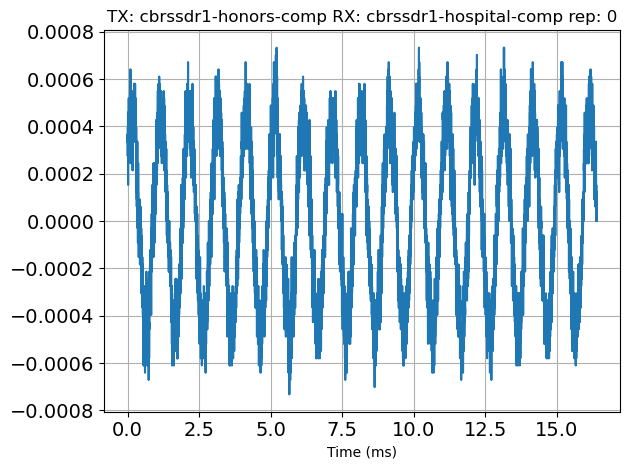

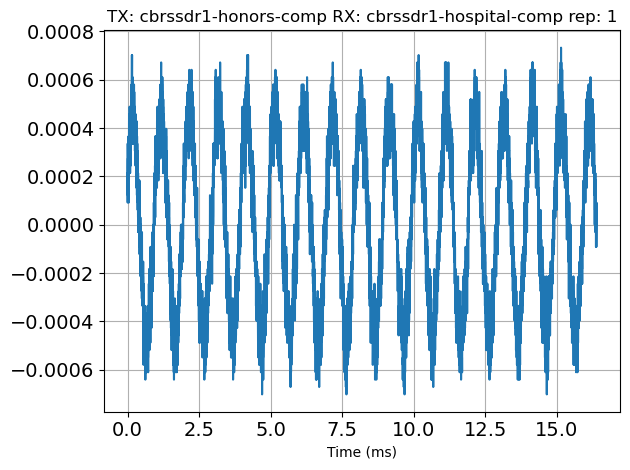

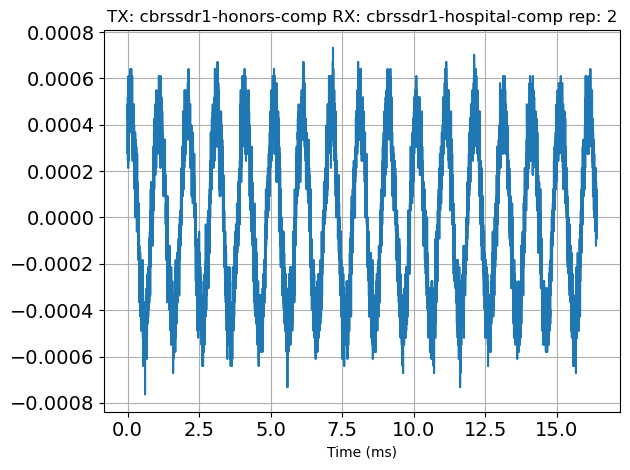

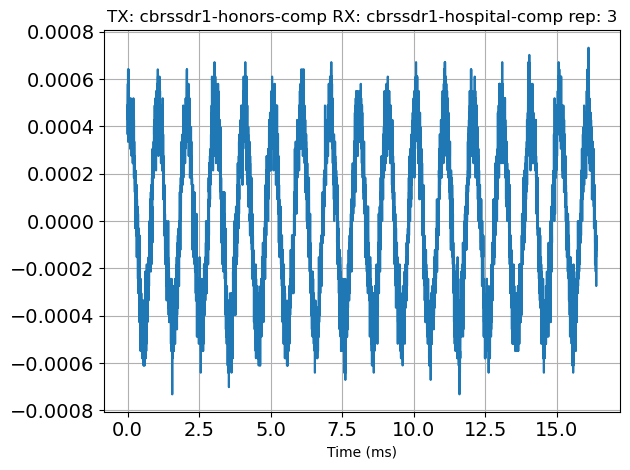

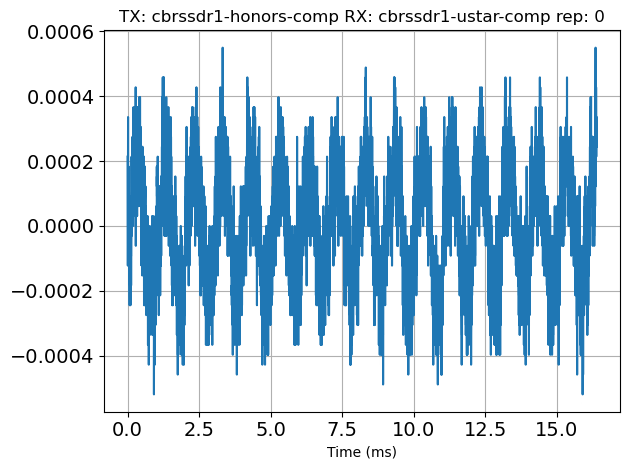

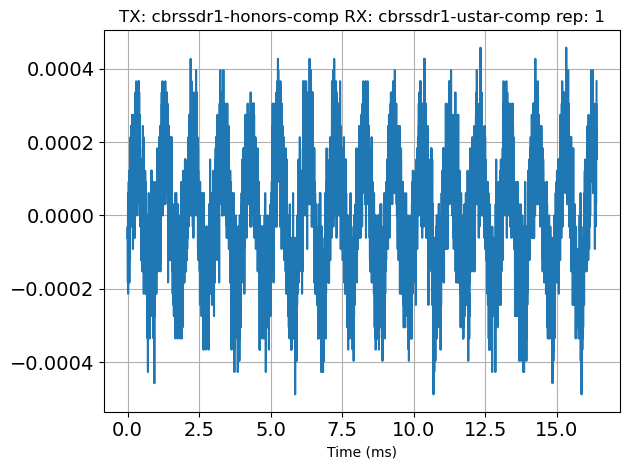

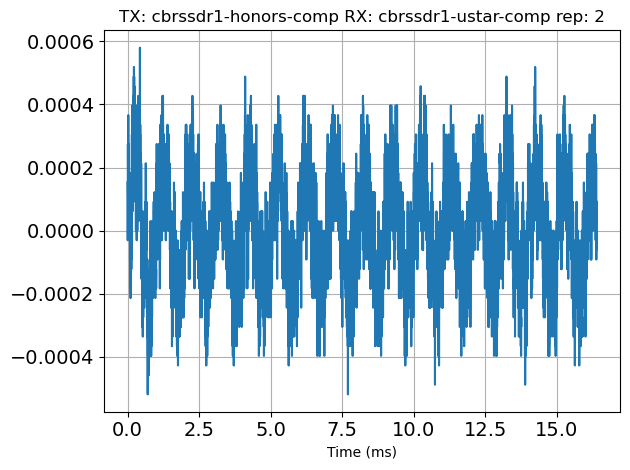

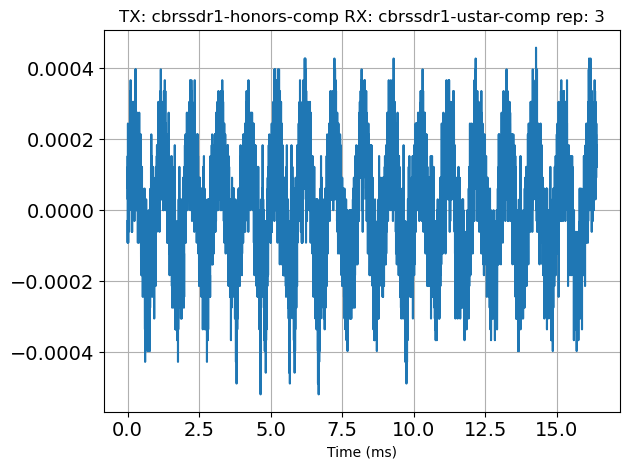

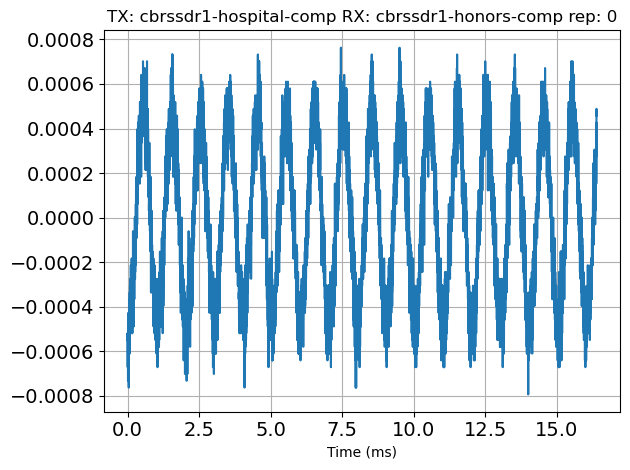

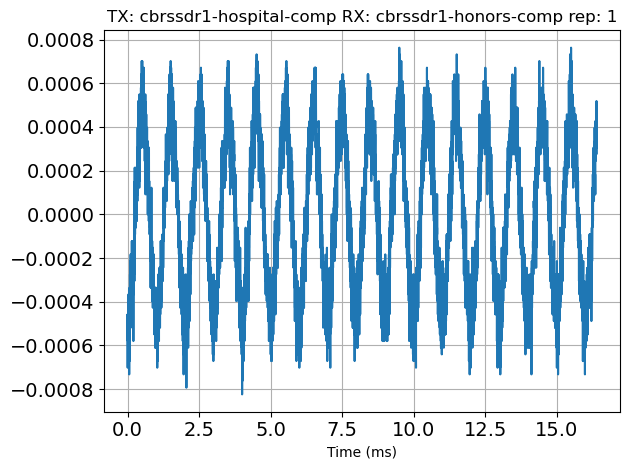

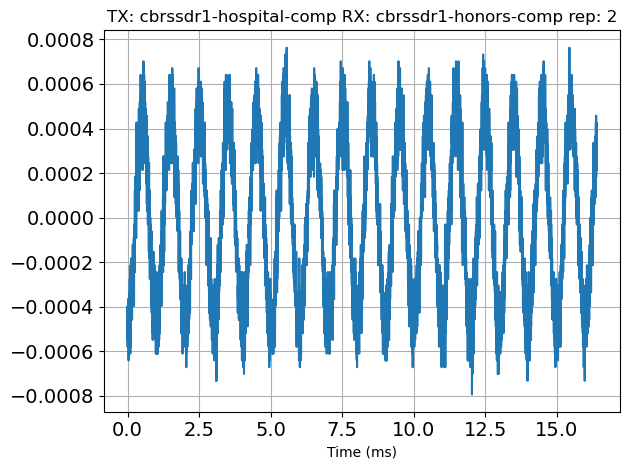

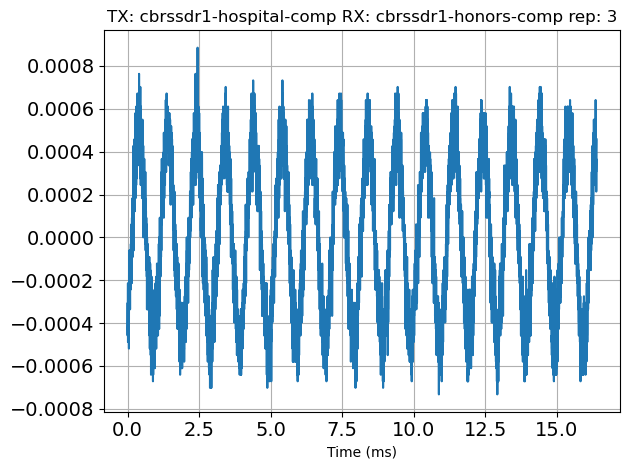

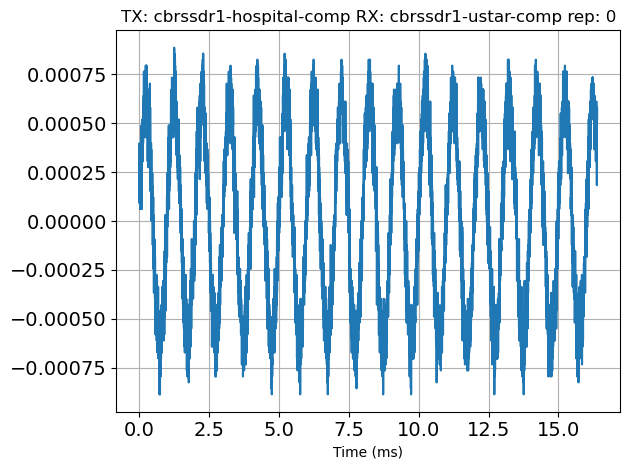

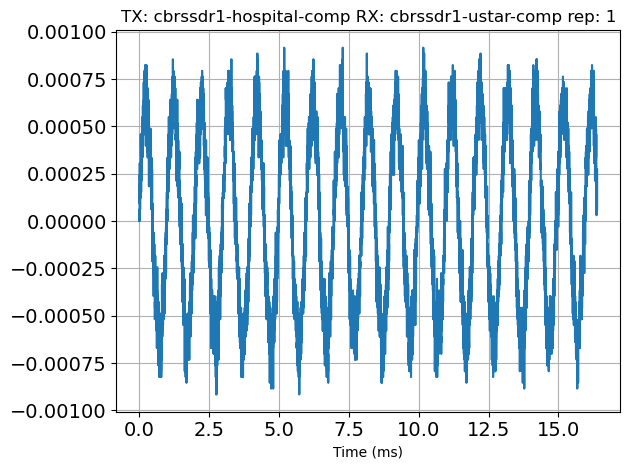

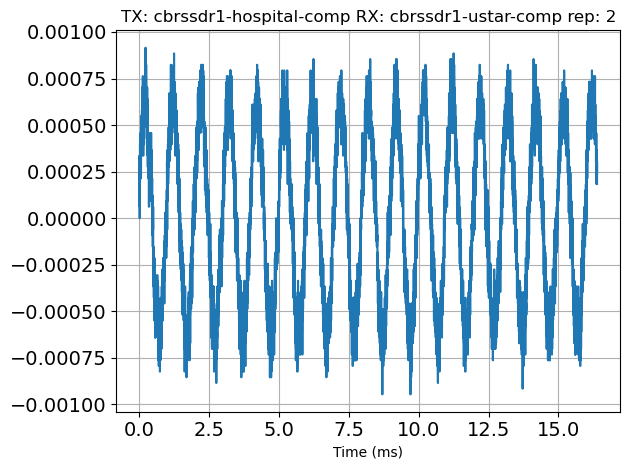

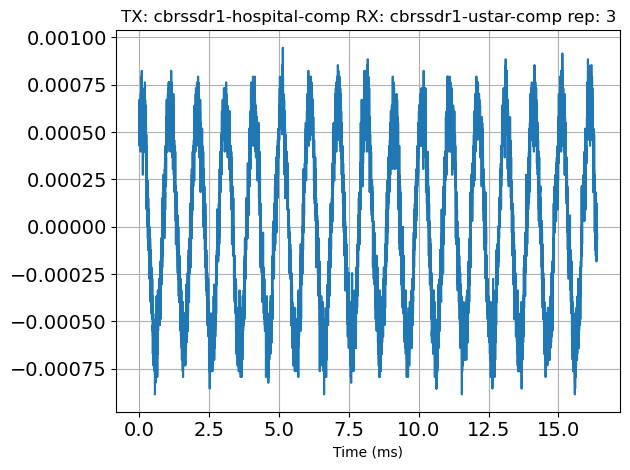

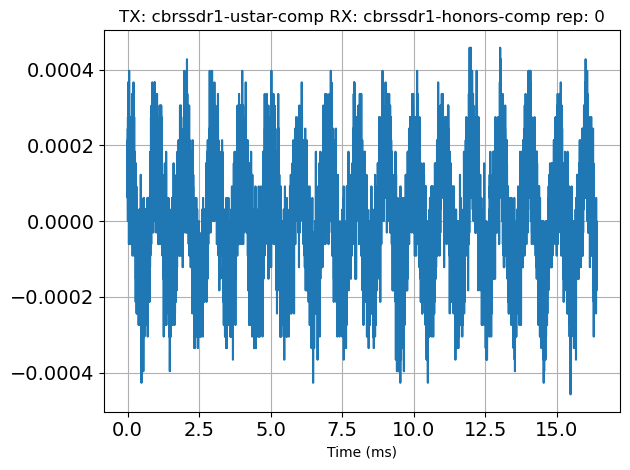

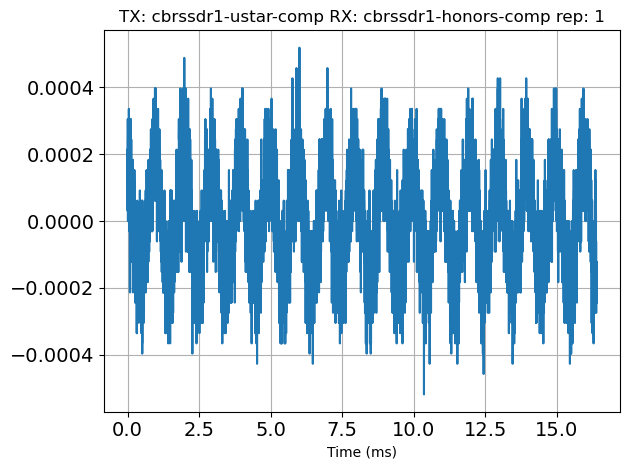

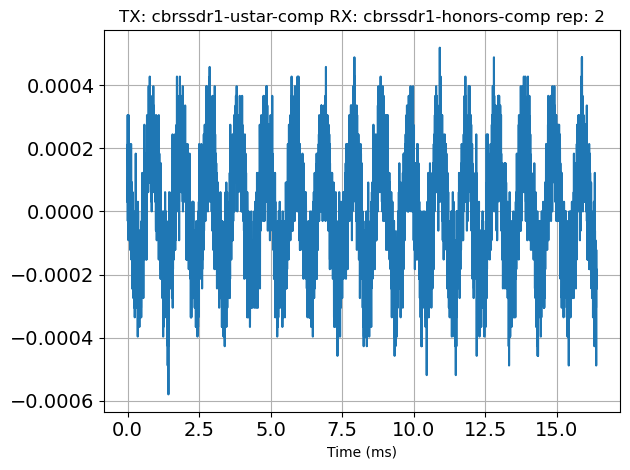

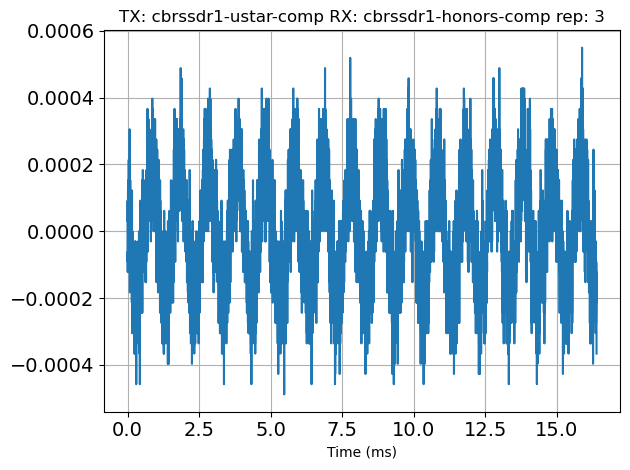

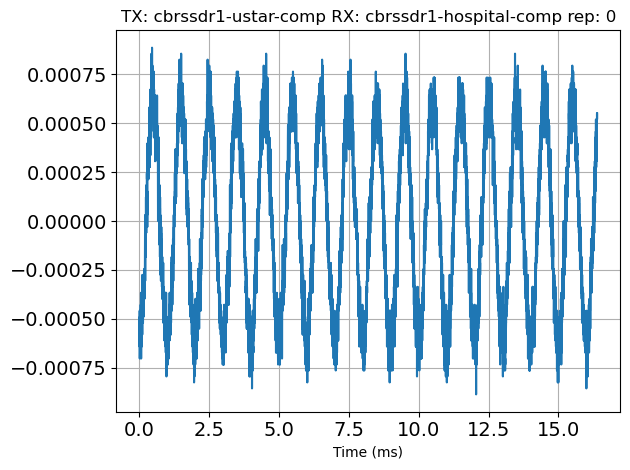

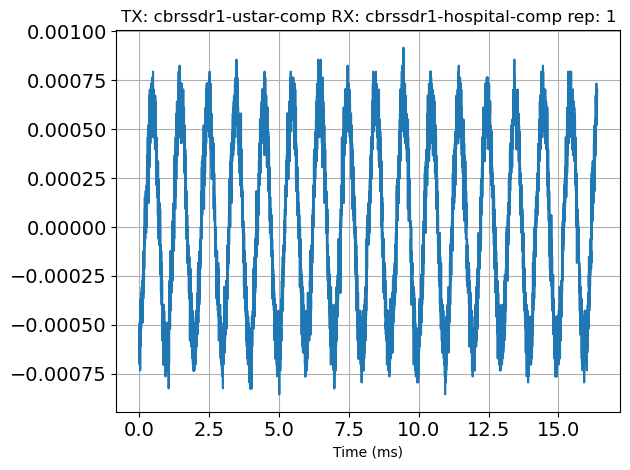

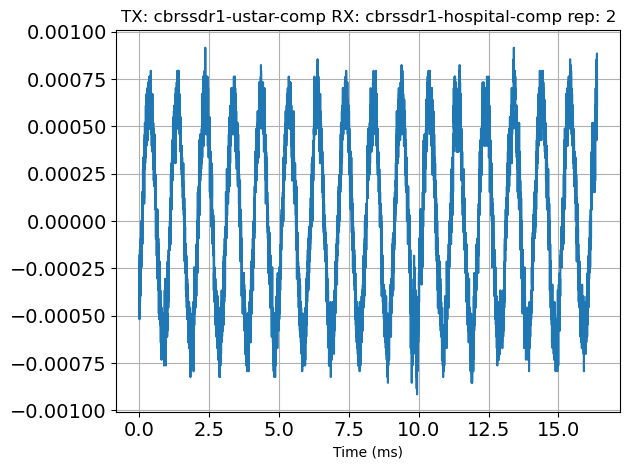

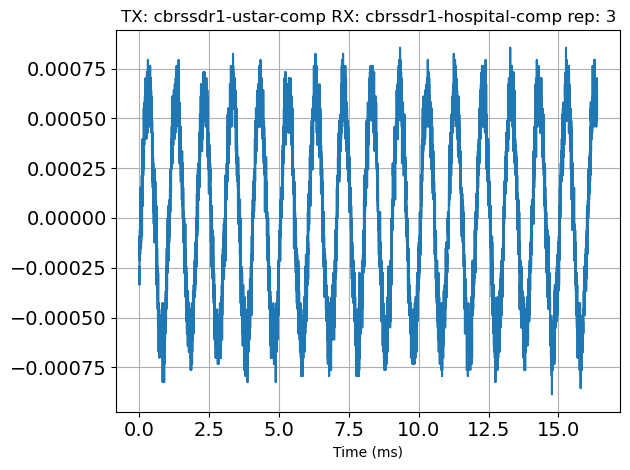

In [3]:
def plotSignalForAllLinks(rx_data, txrxloc, samp_rate=250000, repeats=4):
    for txname in rx_data:
        for i in range(0, len(rx_data[txname])):
            for j in range(0, len(rx_data[txname][i])):
                n = np.arange(len(rx_data[txname][i][j]))/(samp_rate/1000)
                plt.figure()
                plt.plot(n, np.real(rx_data[txname][i][j]))
                plt.grid('on')
                plt.title('TX: {} RX: {} rep: {}'.format(txname, txrxloc[txname][i], j))
                plt.xlabel('Time (ms)')
                plt.tight_layout()
                plt.show()

# plot all links' time-domain signals (just the real part)
# User should check to see these are not empty
plotSignalForAllLinks(rx_data, txrxloc, samp_rate, rxrepeat)



🐋 What do you observe in the time-domain signal? 
1. Does the period you see in the plot match with the CW signal frequency that you expected to see? Describe why it matches (or doesn't match)
2. What are other differences you observe in the other time domain signals?

**Type your answer here.**

### Frequency Domain signals

The power spectral density (PSD) plot shows the squared magnitude of the fast Fourier transform (FFT) of the time domain signal. The 

Feel free to zoom in on the plots by adding a `plt.xlim(x_low, x_high)` command after the `plt.ylim()` command.


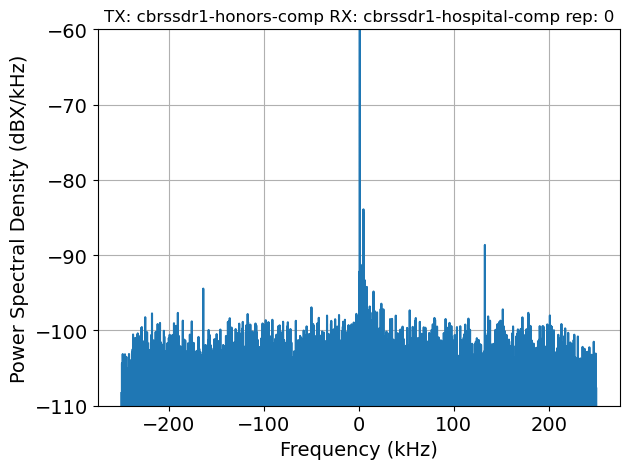

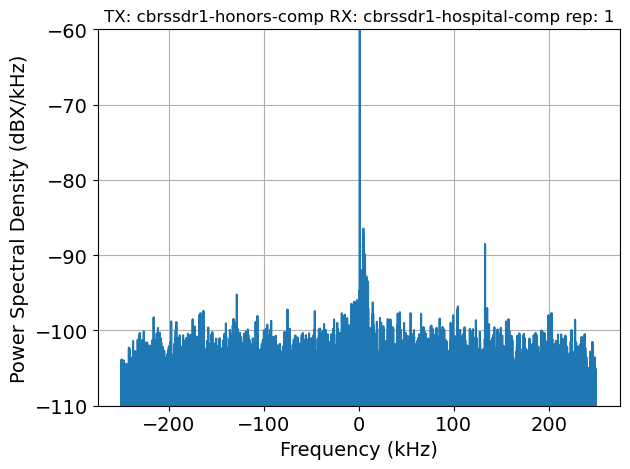

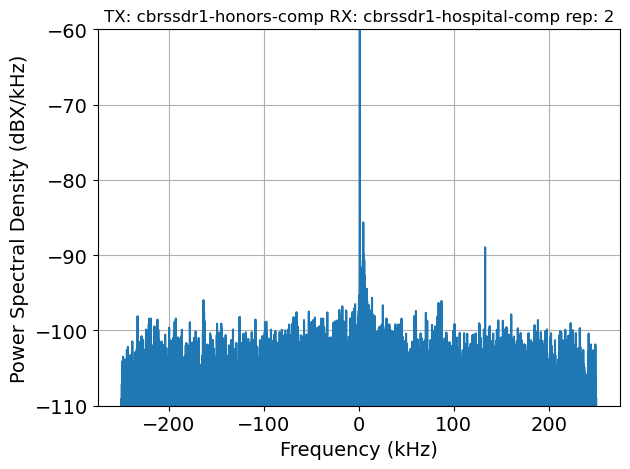

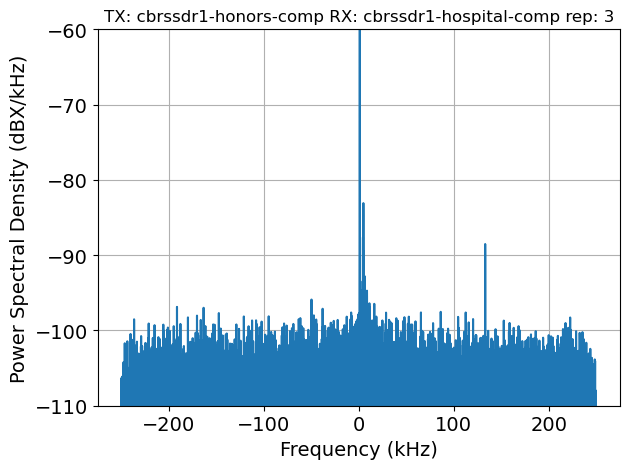

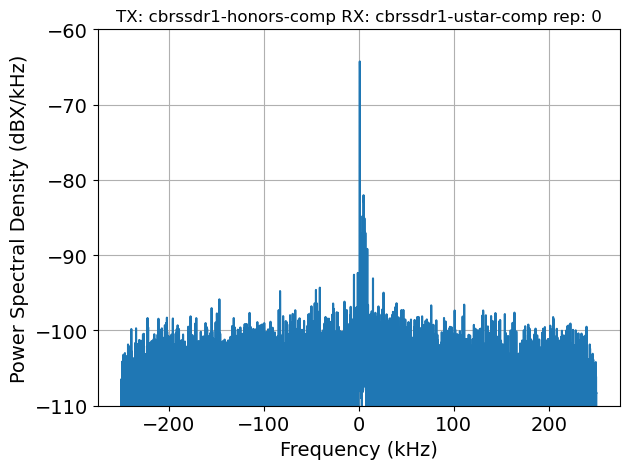

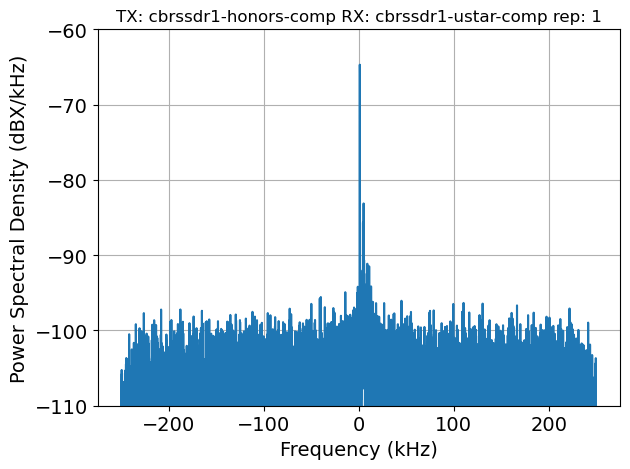

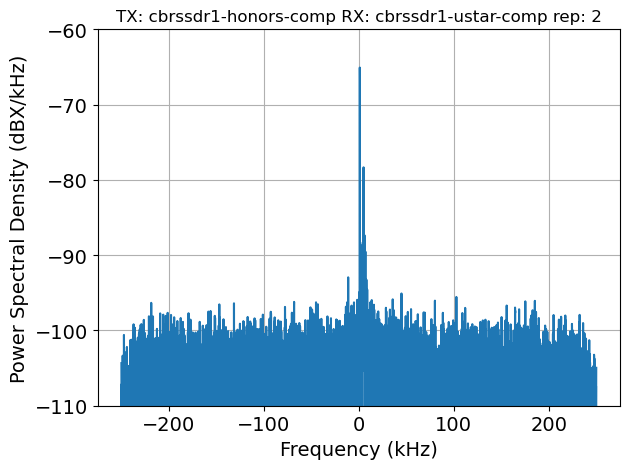

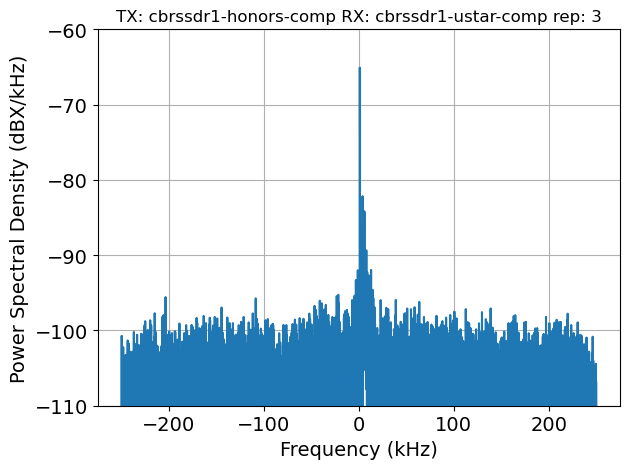

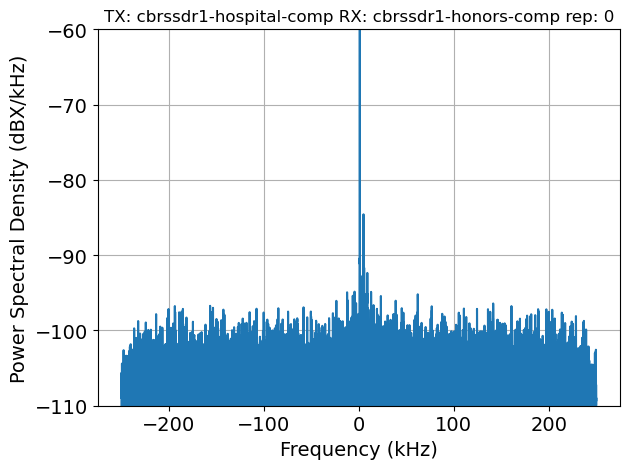

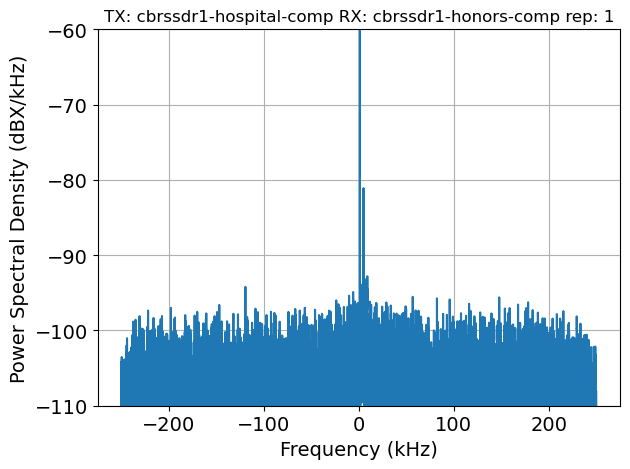

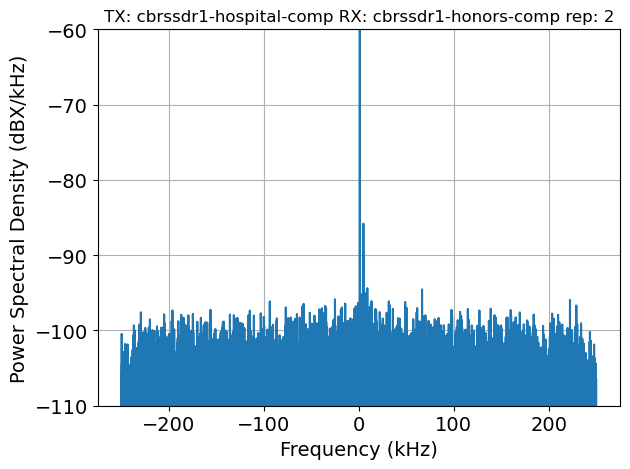

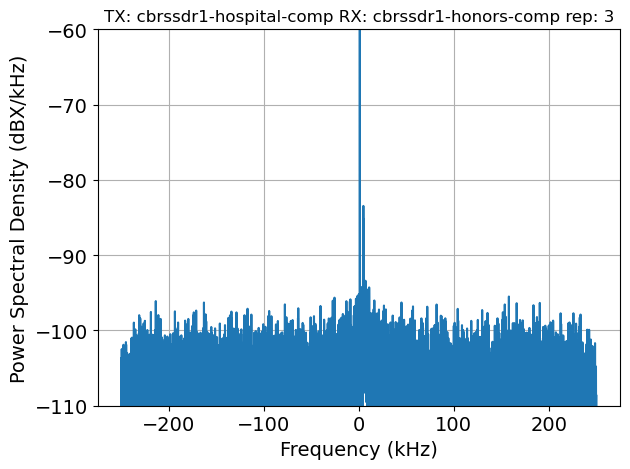

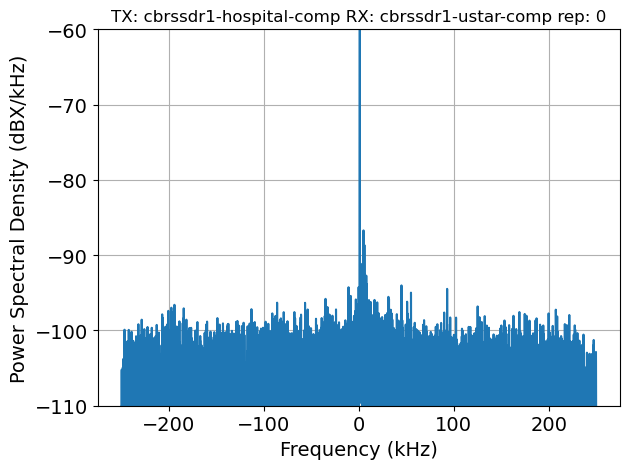

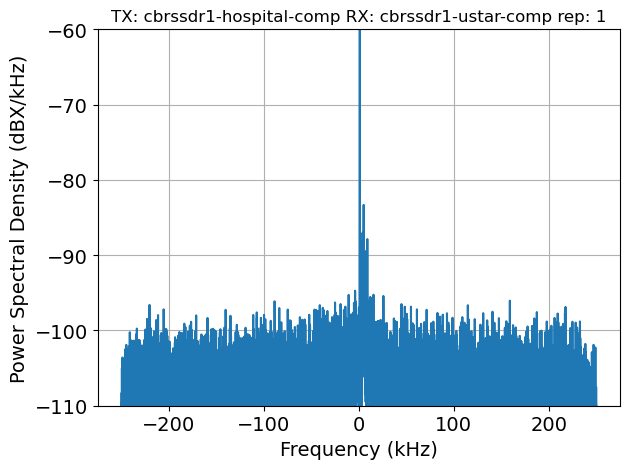

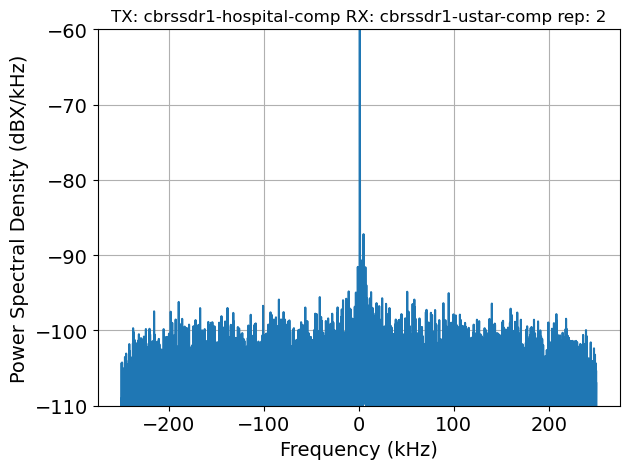

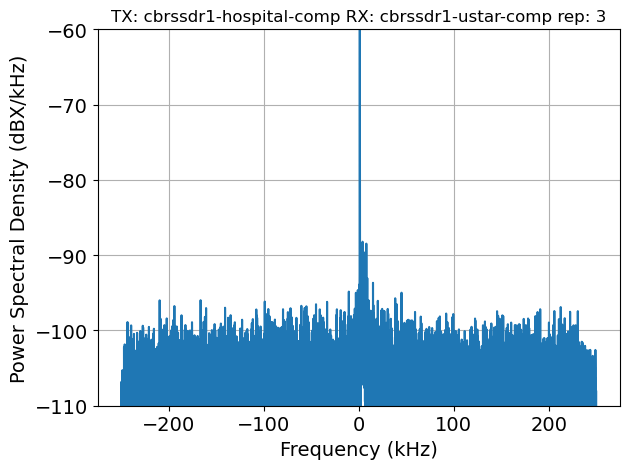

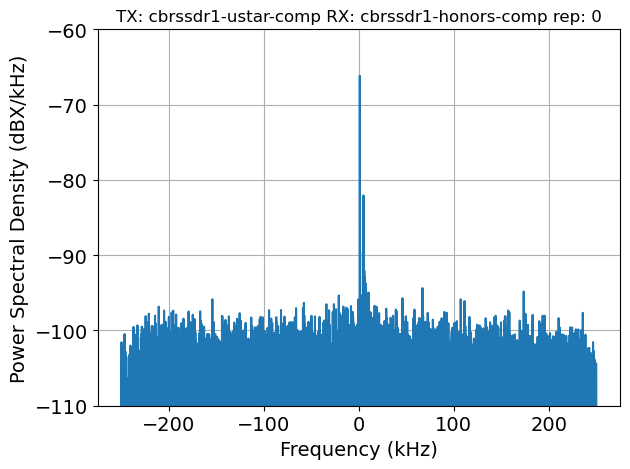

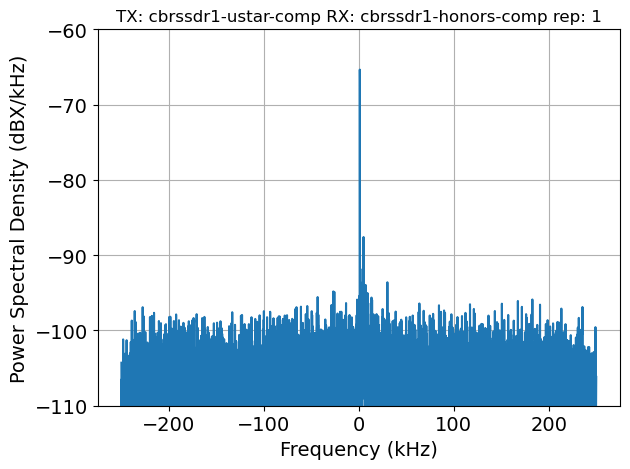

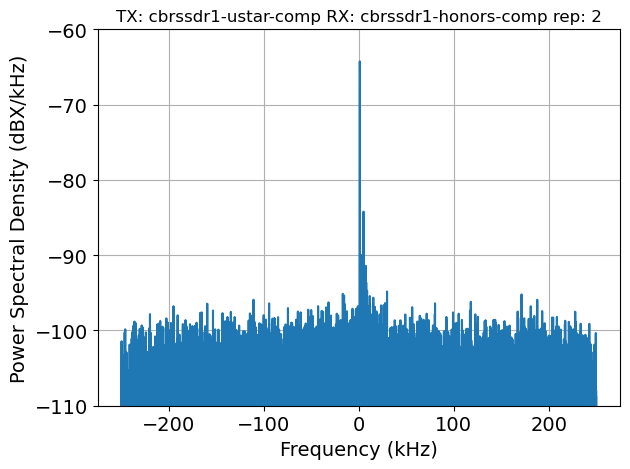

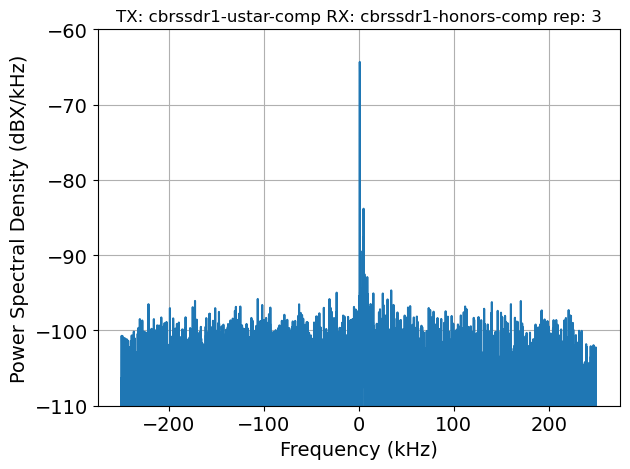

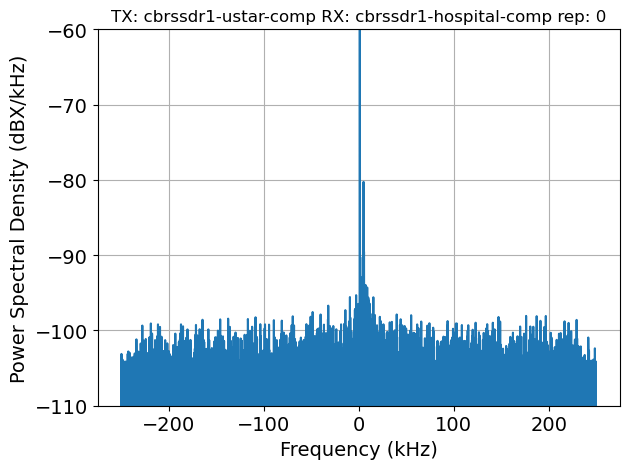

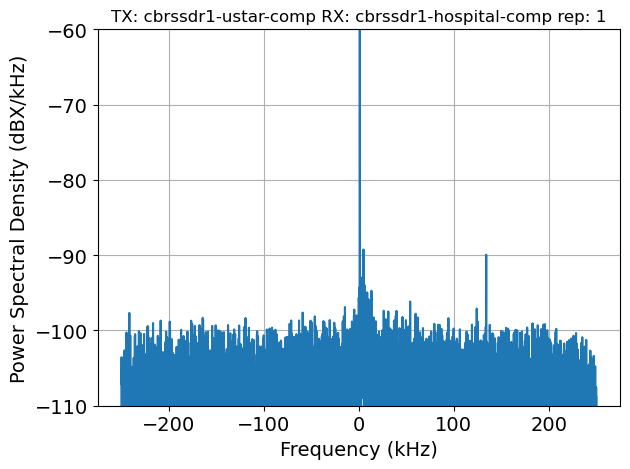

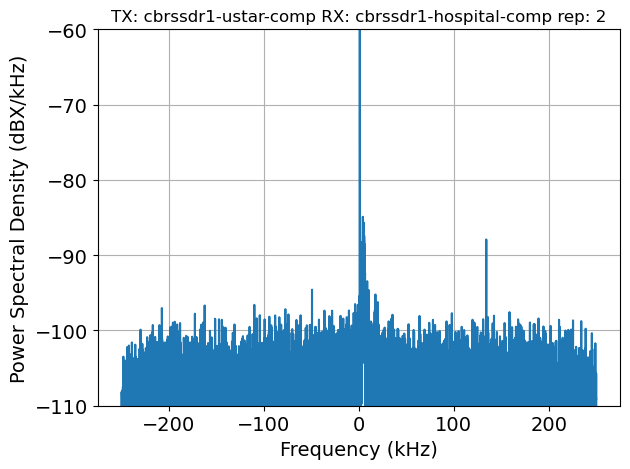

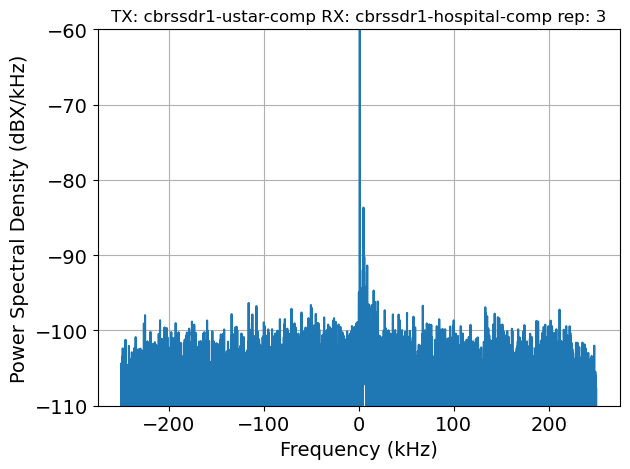

In [4]:
def plotOnePSDForEachLink(rx_data, txrxloc, samp_rate=250000, repeats=4):
    for txname in rx_data:
        print(txname)
        for i in range(0, len(rx_data[txname]), repeats):
            plt.figure()
            # This code arbitrarily picks the 0 rep to plot.
            signalToPlot = rx_data[txname][i][3]
            plt.psd(signalToPlot, Fs = samp_rate/1000, NFFT=len(signalToPlot))
            plt.ylim(-110, -60)
            plt.yticks(ticks=[-110, -100, -90, -80, -70, -60])
            plt.grid('on')
            plt.title('TX: {} RX: {}'.format(txname, txrxloc[txname][i]))
            plt.xlabel('Frequency (kHz)')
            plt.tight_layout()
            plt.show()


def plotPSDForAllLinks(rx_data, txrxloc, samp_rate=250000, repeats=4):
    for txname in rx_data:
        for i in range(0, len(rx_data[txname])):
            for j in range(0, len(rx_data[txname][i])):
                plt.figure()
                signalToPlot = rx_data[txname][i][j]
                plt.psd(signalToPlot, Fs = samp_rate/1000, NFFT=len(signalToPlot))
                plt.ylim(-110, -60)
                plt.yticks(ticks=[-110, -100, -90, -80, -70, -60])
                plt.grid('on')
                plt.title('TX: {} RX: {} rep: {}'.format(txname, txrxloc[txname][i], j), )
                plt.xlabel('Frequency (kHz)', fontsize=14)
                plt.ylabel('Power Spectral Density (dBX/kHz)', fontsize=14)
                plt.tight_layout()
                plt.show()

# plot all links Power spectral density
# User should see that the PSD of the signal (which is close to 0) is mostly stronger than the noise
plotPSDForAllLinks(rx_data, txrxloc, samp_rate, rxrepeat)


🐋 What do you observe in the time-domain signal? 
1. What frequency range is the CW received signal located the power-spectral density plot?
2. How would you describe the frequency content of the received signal?

**Type your answer here**

## 3. Compute the received power in the narrowband received signal

The narrowband signal should be a very narrow band around the sinusoid frequency that we specified in the Shout experiment. In mine, it was 1.0 kHz. Compared to the sampling rate, 500 kHz, this is very small. Computing the power in the entire sampled signal would include the power of the noise across a relatively very large bandwidth, and would artificially increase the received power estimate. 

Instead, we use the FFT and PSD as a way to filter the received power. We integrate the power across a narrow band (plus or minus `approx_halfbandwidth`) around the frequency of the CW signal `sine_wfreq`. There is a tradeoff for the approx_halfbandwidth value -- too high and we'll let more noise in, and too low will eliminate some of the power from our signal. Generally, unless the SNR is very low, the noise power is small compared to the signal power, and having a wider approx_halfbandwidth doesn't affect the signal power much.

Note that `Psd` is linear power per kHz. It is per kHz, rather than per Hz, because I divided the sample rate by 1000. I believe it is more intuitive to show the plot in kHz, rather than Hz. Also, the units of linear power here are pretty close to mW, but we don't have calibration data for the receiver to really know the characteristics of the particular SDR, so I call this reference X mW. Thus when we convert it to decibels, I refer it to "dBX", that is, referred to X mW, and X is unknown.

The plot overwrites itself, so only the last PSD is shown. The blue line is the full PSD. The green line shows the portion of the PSD which we integrate to calculate the received power. 

                         cbrssdr1-honors-comp cbrssdr1-hospital-comp    cbrssdr1-ustar-comp
  cbrssdr1-honors-comp                   0.00                 -66.58                 -74.20
cbrssdr1-hospital-comp                 -66.33                   0.00                 -63.97
   cbrssdr1-ustar-comp                 -74.61                 -64.02                   0.00


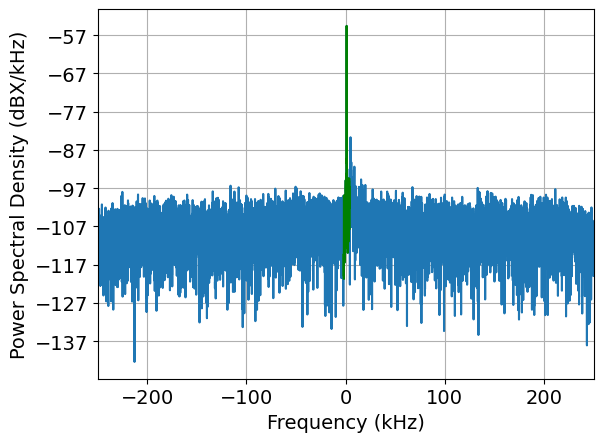

In [6]:
def printRSSMeasurementsGrid(avgRxPowers, names):
    maxchars = max([len(x) for x in names])
    # Print header row with names of transmitters
    print(' '*maxchars, ' '.join(format(x, ">22s") for x in names))
    for rowname in names:
        print( "%22s" % rowname, end='')
        for colname in names:
            print( "%23.2f" % avgRxPowers[rowname][colname], end='')
        print()

def calcRxPowerFreqDomain(complexsignal, samp_rate_kHz, sine_wfreq=1.0, approx_halfbandwidth=6.0):

    #fig, ax = plt.subplots()

    # Calculate the PSD
    plt.close()
    plt.figure(1)
    Psd, freqs = plt.psd(complexsignal, Fs = samp_rate_kHz, NFFT=len(complexsignal))
    df = freqs[1] - freqs[0]
    plt.xlim(-samp_rate_kHz/2, samp_rate_kHz/2)
    plt.xlabel("Frequency (kHz)", fontsize=14)
    plt.ylabel(r"Power Spectral Density (dBX/kHz)", fontsize=14)
    #ax.set_box_aspect(1)

    centerfreq_kHz = sine_wfreq / 1000
    ind = np.where(np.abs(freqs-centerfreq_kHz)<=approx_halfbandwidth)
    plt.plot(freqs[ind], 10*np.log10(Psd[ind]), 'g-')

    return 10*np.log10(sum(Psd[ind]) * df)

# Initialize a 2D dictionary array, each containing an array of the "rxrepeat" number of received powers.
allRxPowers = {y: dict( {w: np.zeros(rxrepeat) for w in rxlocs} ) for y in txlocs}
avgRxPowers = {y: dict( {w: 0 for w in rxlocs} ) for y in txlocs}

# Loop through each measurement (RX, TX, and repetition) in the rx_data structure.
samp_rate_kHz = samp_rate / 1000
for txname in rx_data:
    for i in range(0, len(rx_data[txname])):
        rxname = txrxloc[txname][i]
        for j in range(0, len(rx_data[txname][i])):
            allRxPowers[txname][rxname][j] = calcRxPowerFreqDomain(rx_data[txname][i][j], samp_rate_kHz, sine_wfreq, 3.0)

        # Store the average power over all repetitions
        avgRxPowers[txname][rxname] = np.mean(allRxPowers[txname][txrxloc[txname][i]])

printRSSMeasurementsGrid(avgRxPowers, rxlocs)

🐋 Questions:
1. How much does the received power estimate change if we integrate over a `approx_halfbandwidth=1` kHz? Or `approx_halfbandwidth=10` kHz?
2. The NFFT= argument to the psd() function is the FFT length. It can be set smaller than the number of samples to reduce computation. How much does the received power estimate change if we use an NFFT of 256 instead of 8192?

**Type your answer here**

## 4. Compare path lengths to the measured received powers

In this part, plot the received powers vs. logarithmic distance. This will help us get to a model for received power as a function of the log of distance.

I have previously computed the distances between nodes (including all rooftop and dense deployment SDRs). This is in a python pickle file that contains `distance_data`, a structure that contains:
- `allnames`: A list of the name strings of all of the nodes. Here, the string does not include "-comp" because the distances are really between the SDRs, not the computers connected to them (which may be far, far away). 
- `distance_m`: 2D array of distances between each pair of nodes in the list. Distances are in meters.

In this part, extract the distances of importance into `my_distances`.

In [7]:
def printDistanceGrid(my_distances, names):
    maxchars = max([len(x) for x in names])
    # Print header row with names of transmitters
    print(' '*maxchars, ' '.join(format(x, ">22s") for x in names))
    for i, rowname in enumerate(names):
        print( "%22s" % rowname, end='')
        for j, colname in enumerate(names):
            print( "%23.2f" % my_distances[i,j], end='')
        print()


# Load the distances between nodes data pickle
with open('distance_data.pkl', 'rb') as f:
    distance_data = pickle.load(f)

# Unpack the loaded data
distance_m, allnames = distance_data
print(allnames)

# Radio names in the csv don't have the "-comp" ending
my_radio_names = [x.replace('-comp', '') for x in rxlocs]
# Find the indices of these "my_radio_names" within the "allnames" list
ind = [allnames.index(txname) for txname in my_radio_names]
# Get the submatrix of distance_m for my_radio_names (with rows & cols equal to ind)
my_distances = distance_m[ind,:][:, ind]

printDistanceGrid(my_distances, rxlocs)

['cbrssdr1-honors', 'cbrssdr1-bes', 'cbrssdr1-fm', 'cbrssdr1-browning', 'cbrssdr1-meb', 'cbrssdr1-ustar', 'cbrssdr1-hospital', 'cnode-wasatch', 'cnode-mario', 'cnode-moran', 'cnode-guesthouse', 'cnode-ebc', 'cnode-ustar']
                         cbrssdr1-honors-comp cbrssdr1-hospital-comp    cbrssdr1-ustar-comp
  cbrssdr1-honors-comp                   0.00                 739.41                 646.40
cbrssdr1-hospital-comp                 739.41                   0.00                 446.44
   cbrssdr1-ustar-comp                 646.40                 446.44                   0.00


Next, make the plot of received power vs. dB distance, that is, 10*log10(distance). Put the relevant distances into a 1D array. Then put the received powers into the same length 1D array, so that the ith received power corresponds to the ith distance. Then plot the figure.

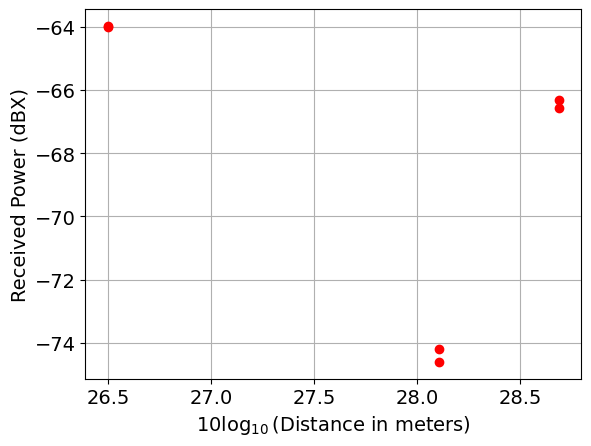

In [8]:
# Create a 1-D array of path lengths (distances) in meters
# Create a 1-D array of received powers in dBX for the same links
dist_vec = np.array([])
power_vec = np.array([])

# Loop through each measurement in avgRxPowers (which is a Python dictionary of dictionaries)
for txname, rxPowerDict in avgRxPowers.items():
    tx_ind = allnames.index(txname.replace('-comp', ''))
    for rxname, rxPower in rxPowerDict.items():
        rx_ind = allnames.index(rxname.replace('-comp', ''))        
        if rxPower < 0:
            power_vec = np.append(power_vec, rxPower)
            dist_vec = np.append(dist_vec, distance_m[tx_ind, rx_ind])

# Plot the received power vs. 10*log10(distance) as a scatter plot.
plt.figure()
plt.plot(10*np.log10(dist_vec), power_vec, 'ro')
plt.xlabel(r'10$\log_{10}$(Distance in meters)', fontsize=14)
plt.ylabel('Received Power (dBX)', fontsize=14)
plt.grid()

🐋 Question: What can you observe in your (limited) data about the received power?

**Type your answer here**